In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import librairies

In [ ]:
import pandas as pd
import ast
#import lux
import seaborn as sns
import plotly.express as px

#populating the interactive namespace from numpy and matplotlib
%pylab inline

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, accuracy_score, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import *

from time import time

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Import Dataset

In [ ]:
energy_2015_2016 = pd.read_csv('/content/drive/My Drive/openclassroom/Pélec_sooprayen_oorvasi/Dataset/final.csv', index_col=0)

# Description des données

In [ ]:
print("Le jeu de données energy_2015_2016 contient %d lignes et %d colonnes." % (energy_2015_2016.shape[0], energy_2015_2016.shape[1]))

Le jeu de données energy_2015_2016 contient 2788 lignes et 35 colonnes.


In [ ]:
energy_2015_2016.tail()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Latitude,Longitude,Address,City,State,ZipCode,log-TotalGHGEmissions,log-SiteEnergyUse
3371,50222,2016,Nonresidential COS,Office,GREATER DUWAMISH,1990,1.0,1.0,12294.0,0,12294,Office,12294.0,Nothing,0.0,Nothing,0.0,46.0,69.099998,161.699997,8.497457e+05,0.0,5.242709e+05,3.254750e+05,20.94,1.70,Error - Correct Default Data,47.56722,-122.31154,1600 S Dakota St,Seattle,WA,98125.0,3.088311,13.652694
3372,50223,2016,Nonresidential COS,Other,DOWNTOWN,2004,1.0,1.0,16000.0,0,16000,Other - Recreation,16000.0,Nothing,0.0,Nothing,0.0,NaN,59.400002,114.199997,9.502762e+05,0.0,3.965461e+05,5.537300e+05,32.17,2.01,Compliant,47.59625,-122.32283,719 8th Ave S,Seattle,WA,98125.0,3.501646,13.764509
3373,50224,2016,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157.0,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,438.200012,744.799988,5.765898e+06,0.0,1.792159e+06,3.973739e+06,223.54,16.99,Compliant,47.63644,-122.35784,1920 1st Ave W,Seattle,WA,98125.0,5.414054,15.567472
3374,50225,2016,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1989,1.0,1.0,14101.0,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,51.000000,105.300003,7.194712e+05,0.0,3.488702e+05,3.706010e+05,22.11,1.57,Compliant,47.52832,-122.32431,8319 8th Ave S,Seattle,WA,98125.0,3.140265,13.486273
3375,50226,2016,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1938,1.0,1.0,18258.0,0,18258,Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,63.099998,115.800003,1.152896e+06,0.0,4.325542e+05,7.203420e+05,41.27,2.26,Compliant,47.53939,-122.29536,2820 S Myrtle St,Seattle,WA,98125.0,3.744078,13.957789


In [ ]:
energy_2015_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2788 entries, 0 to 3375
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    2788 non-null   int64  
 1   DataYear                         2788 non-null   int64  
 2   BuildingType                     2788 non-null   object 
 3   PrimaryPropertyType              2788 non-null   object 
 4   Neighborhood                     2788 non-null   object 
 5   YearBuilt                        2788 non-null   int64  
 6   NumberofBuildings                2788 non-null   float64
 7   NumberofFloors                   2788 non-null   float64
 8   PropertyGFATotal                 2788 non-null   float64
 9   PropertyGFAParking               2788 non-null   int64  
 10  PropertyGFABuilding(s)           2788 non-null   int64  
 11  LargestPropertyUseType           2788 non-null   object 
 12  LargestPropertyUseTy

# Visualisations

In [ ]:
fig = px.scatter_mapbox(energy_2015_2016,
                        lat="Latitude",
                        lon="Longitude",
                        color="PrimaryPropertyType",
                        mapbox_style = "carto-positron",
                        zoom=9.5,
                        hover_data = ["ZipCode"],
                        title="<b>Répartion geographique des immeubles par type</b>")
fig.show()

In [ ]:
energy_2015_2016['ZipCode'] = energy_2015_2016['ZipCode'].apply(str).astype('object')

In [ ]:
df = pd.DataFrame()
sum_missing_values = energy_2015_2016.isnull().sum()
percentage = 100 * sum_missing_values / len(energy_2015_2016)
df['% Missing Values'] = percentage.round(2)
df.style.background_gradient(axis=0, cmap='PuBuGn')

,% Missing Values
OSEBuildingID,0.000000
DataYear,0.000000
BuildingType,0.000000
PrimaryPropertyType,0.000000
Neighborhood,0.000000
YearBuilt,0.000000
NumberofBuildings,0.000000
NumberofFloors,0.000000
PropertyGFATotal,0.000000
PropertyGFAParking,0.000000


# Remplacer les valeurs manquantes

ENERGYSTARScore

In [ ]:
energy_2015_2016.ENERGYSTARScore.describe()

count    1866.000000
mean       64.162379
std        28.728756
min         1.000000
25%        46.250000
50%        72.000000
75%        88.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

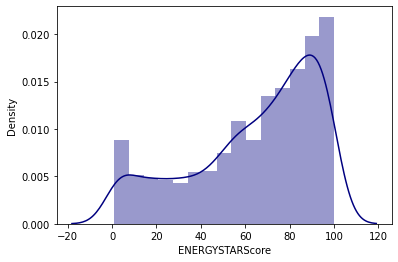

In [ ]:
sns.distplot(energy_2015_2016['ENERGYSTARScore'], color = 'navy')

In [ ]:
numerical_columns = energy_2015_2016.select_dtypes(['int','float']).columns

In [ ]:
numerical_columns[2:-5]

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

#Technique 1: Imputation par la moyenne

In [ ]:
energy_mean = energy_2015_2016.copy()

In [ ]:
missing_col = ['ENERGYSTARScore']
for i in missing_col:
    energy_mean.loc[energy_mean.loc[:,i].isnull(),i]=energy_mean.loc[:,i].mean()

#Technique 2: Imputation par la médianne

In [ ]:
energy_median = energy_2015_2016.copy()

In [ ]:
for i in missing_col:
    energy_median.loc[energy_median.loc[:,i].isnull(),i]=energy_median.loc[:,i].median()

#Technique 3: Imputation avec KNN 

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(imputer.fit_transform(energy_2015_2016[numerical_columns[2:-5]]), columns=energy_2015_2016[numerical_columns[2:-5]].columns)

In [ ]:
df_knn.shape

(2788, 17)

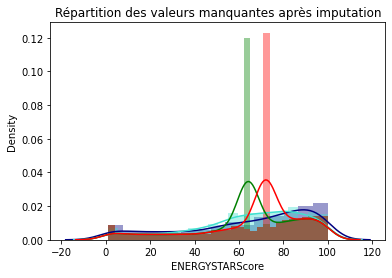

In [ ]:
#après imputation
sns.distplot(energy_2015_2016['ENERGYSTARScore'], color = 'navy').set(title='Répartition des valeurs manquantes après imputation')
sns.distplot(df_knn['ENERGYSTARScore'], color = 'turquoise')
sns.distplot(energy_mean['ENERGYSTARScore'], color = 'green')
sns.distplot(energy_median['ENERGYSTARScore'], color = 'red')

On applique la méthode KNN comme imputation car c'est mieux réparti

In [ ]:
for col in numerical_columns[2:-5]:
    energy_2015_2016[col] = df_knn[col].values

In [ ]:
energy_2015_2016.shape

(2788, 35)

In [ ]:
df = pd.DataFrame()
sum_missing_values = energy_2015_2016.isnull().sum()
percentage = 100 * sum_missing_values / len(energy_2015_2016)
df['% Missing Values'] = percentage.round(2)
df.style.background_gradient(axis=0, cmap='PuBuGn')

,% Missing Values
OSEBuildingID,0.000000
DataYear,0.000000
BuildingType,0.000000
PrimaryPropertyType,0.000000
Neighborhood,0.000000
YearBuilt,0.000000
NumberofBuildings,0.000000
NumberofFloors,0.000000
PropertyGFATotal,0.000000
PropertyGFAParking,0.000000


# Variables quantitatives

In [ ]:
numerical_cols = energy_2015_2016.select_dtypes(['int','float']).columns

In [ ]:
numerical_cols

Index(['OSEBuildingID', 'DataYear', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Latitude', 'Longitude', 'log-TotalGHGEmissions', 'log-SiteEnergyUse'],
      dtype='object')

Text(0.5, 1.0, 'Visualisation des valeurs manquantes')

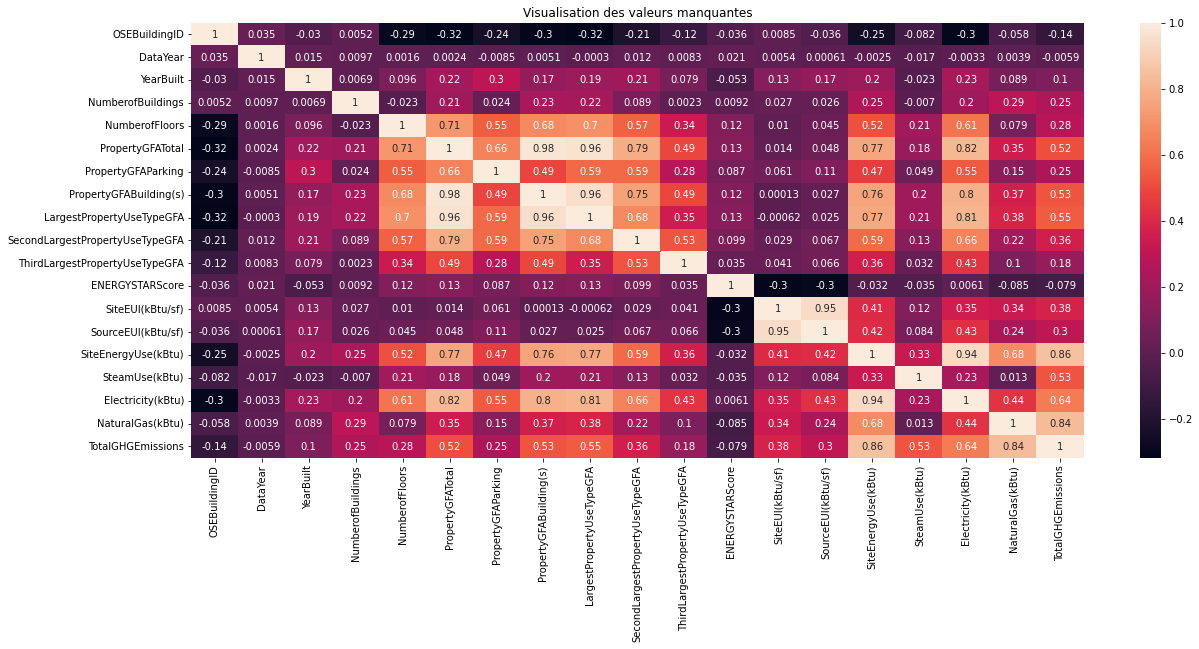

In [ ]:
corr = energy_2015_2016[numerical_cols[:-5]].corr()
plt.figure(figsize=(20,8))
sns.heatmap(corr, annot=True)
plt.title('Visualisation des valeurs manquantes')

On remarque sur ce Heatmap de fortes corrélations linéaires entre plusieurs variables, peut être du à une fuite de donnée et peuvent amener des problèmes de colinéarité dans nos futurs modèles.

Isolons les paires de variables avec des corrélations de Pearson supérieurs à 75% pour mieux comprendre leur relation :

In [ ]:
threshold = 0.75
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
26,PropertyGFATotal,PropertyGFABuilding(s),0.978503
24,PropertyGFATotal,LargestPropertyUseTypeGFA,0.964141
22,LargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.956452
20,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.948470
18,Electricity(kBtu),SiteEnergyUse(kBtu),0.939779
16,TotalGHGEmissions,SiteEnergyUse(kBtu),0.855091
14,NaturalGas(kBtu),TotalGHGEmissions,0.836192
12,PropertyGFATotal,Electricity(kBtu),0.821458
10,LargestPropertyUseTypeGFA,Electricity(kBtu),0.809592
8,PropertyGFABuilding(s),Electricity(kBtu),0.802588


SiteEUI(kBtu/sf) : Energy Use Intensity (EUI) ou intensité de la consommation d'énergie ; l'EUI exprime la consommation d'énergie d'un bâtiment en fonction de sa taille ou d'autres caractéristiques.

SourceEUI(kBtu/sf : la source d'énergie est l'unité d'évaluation la plus équitable pour comparer différents bâtiments entre eux. La source d'énergie représente la quantité totale de combustible brut nécessaire au fonctionnement du bâtiment. Il intègre toutes les pertes de transmission, de livraison et de production. En prenant en compte toutes les consommations d'énergie, le score fournit une évaluation complète de l'efficacité énergétique d'un bâtiment.

Le somme de Electricity, NaturalGas, et SteamUse donne SiteEnergyUse

Le but de l'analyse étant de supprimer les relevés coûteux pour les années à venir, on va donc les supprimer.

In [ ]:
energy_2015_2016 = energy_2015_2016.drop(['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)'], axis=1)

Avec cette table de corrélations on peut aussi conclure que PropertyGFATotal et PropertyGFABuilding(s) peuvent en effet être fortement corrélé

Le LargestPropertyUseTypeGFA est corrélé avec PropertyGFATotal et PropertyGFABuilding(s) car il contient principalement que des largest Property qui sont égale au 2 variables

In [ ]:
energy_2015_2016.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ComplianceStatus', 'Latitude', 'Longitude',
       'Address', 'City', 'State', 'ZipCode', 'log-TotalGHGEmissions',
       'log-SiteEnergyUse'],
      dtype='object')

In [ ]:
energy_2015_2016['difference'] = energy_2015_2016['PropertyGFATotal'] - (energy_2015_2016['PropertyGFABuilding(s)']+energy_2015_2016['PropertyGFAParking'])

In [ ]:
energy_2015_2016.difference.value_counts()

0.0    2788
Name: difference, dtype: int64

    PropertyGFATotal est égale à PropertyGFABuilding(s) + PropertyGFAParking

In [ ]:
energy_2015_2016 = energy_2015_2016.drop(['difference','PropertyGFATotal'], axis=1)

In [ ]:
energy_2015_2016.shape

(2788, 29)

In [ ]:
numerical_cols = energy_2015_2016.select_dtypes(['int','float']).columns
numerical_cols

Index(['OSEBuildingID', 'DataYear', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Latitude', 'Longitude', 'log-TotalGHGEmissions', 'log-SiteEnergyUse'],
      dtype='object')

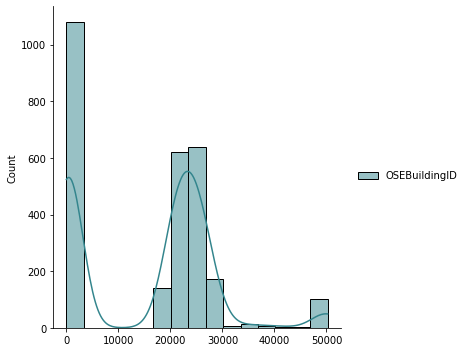

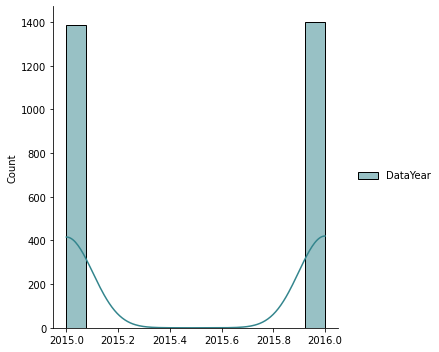

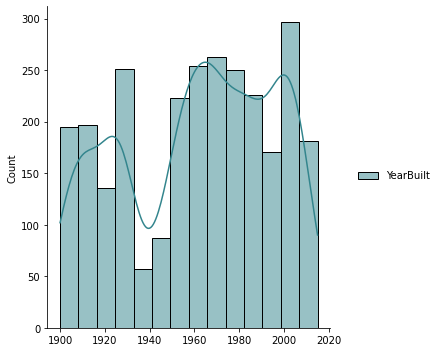

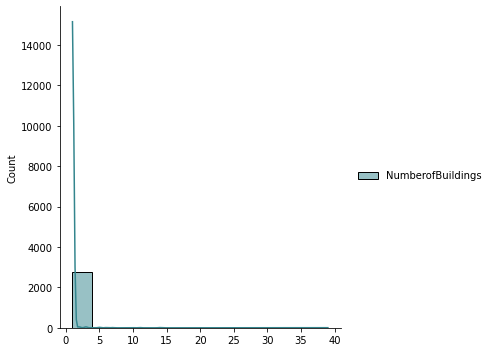

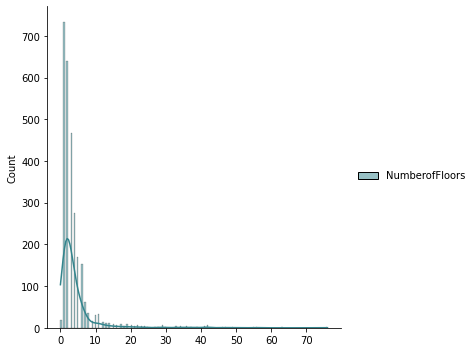

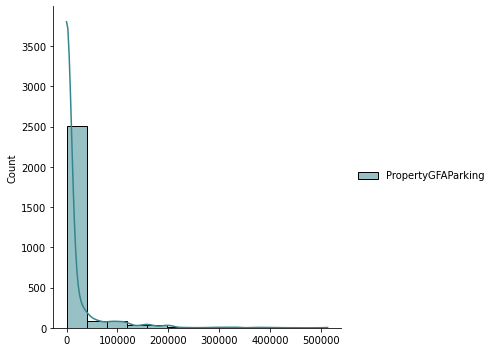

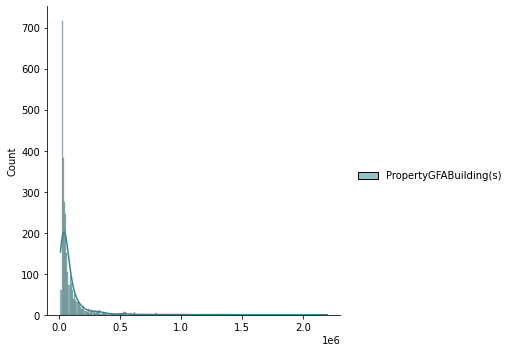

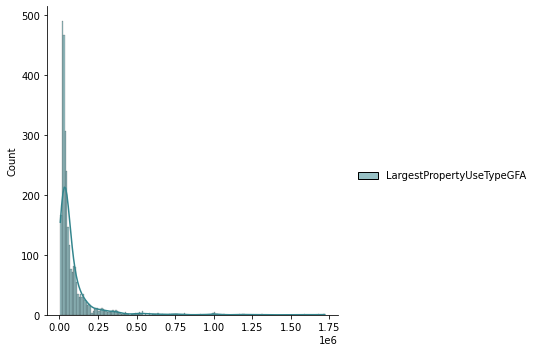

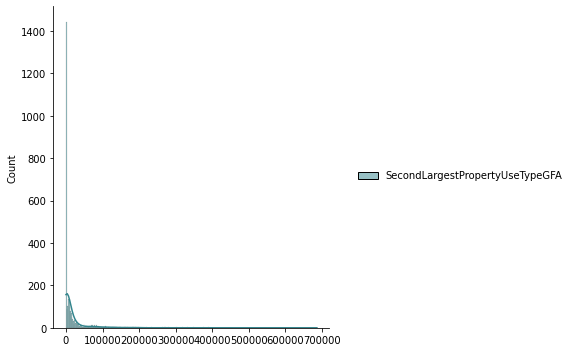

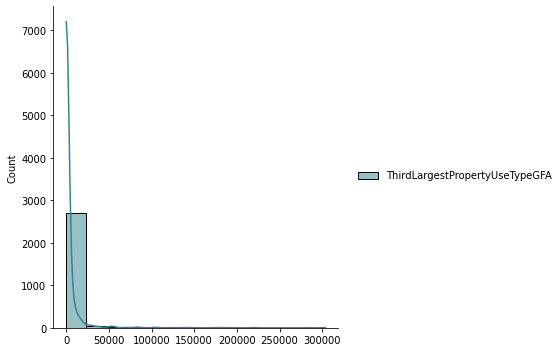

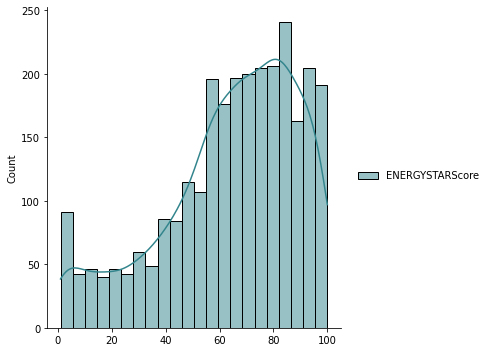

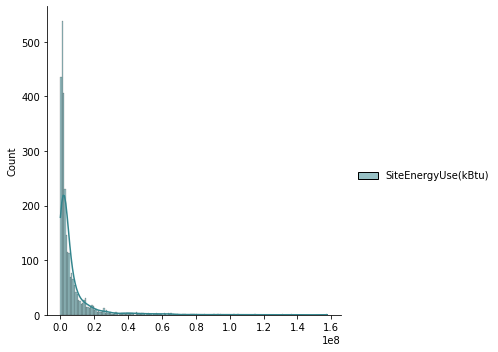

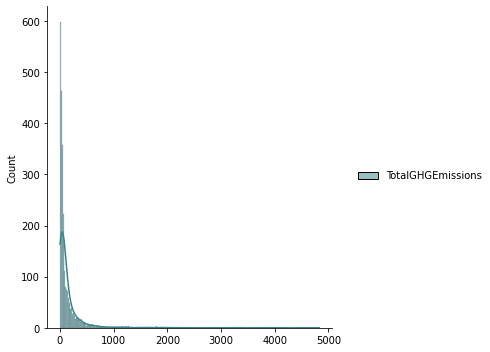

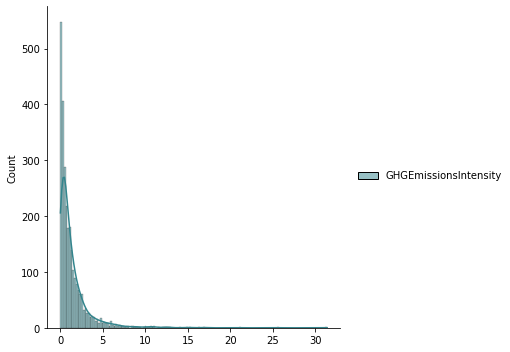

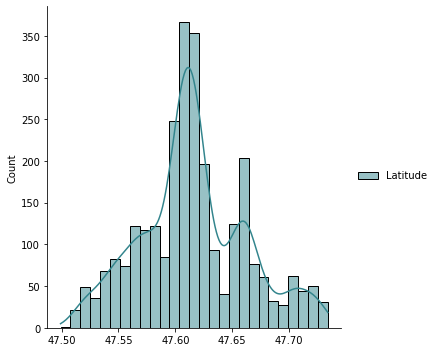

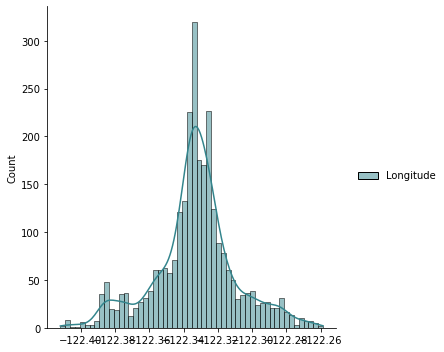

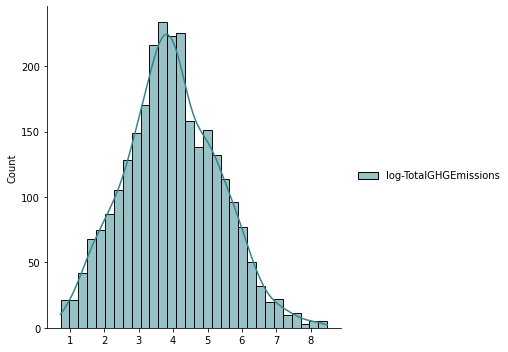

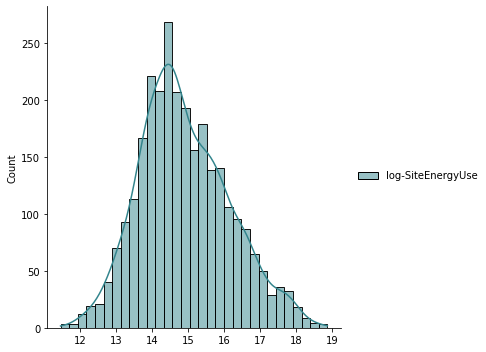

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})
for col in energy_2015_2016[numerical_cols]:
    sns.displot(energy_2015_2016[[col]], kde=True, palette="crest")

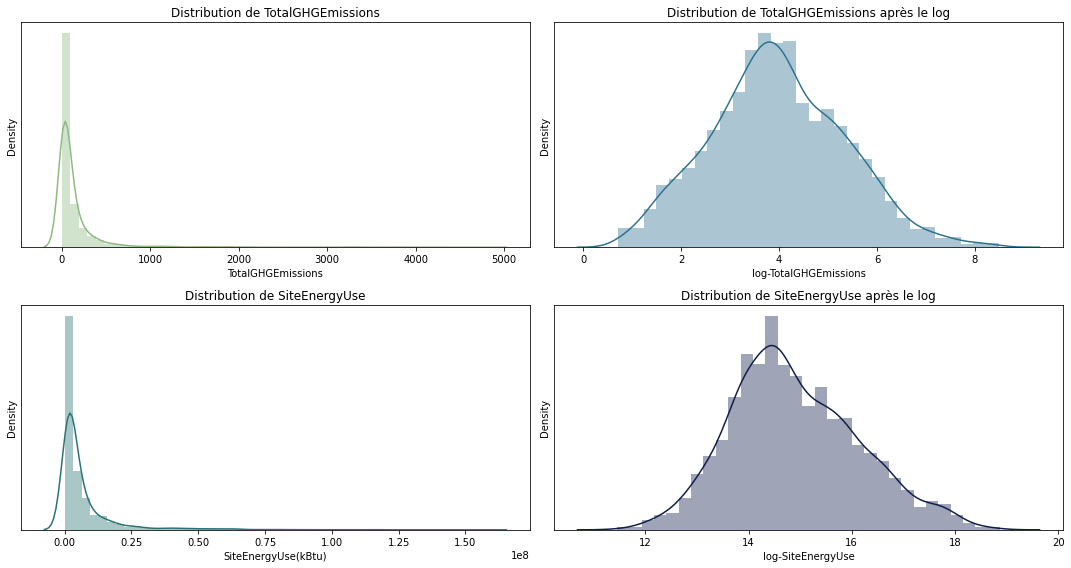

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot a simple distribution of the desired columns
sns.distplot(energy_2015_2016['TotalGHGEmissions'], color="#8cba80",  kde=True, ax=axes[0, 0]).set(title='Distribution de TotalGHGEmissions')
sns.distplot(energy_2015_2016['log-TotalGHGEmissions'], color="#2D728F",  kde=True, ax=axes[0, 1]).set(title='Distribution de TotalGHGEmissions après le log')
sns.distplot(energy_2015_2016['SiteEnergyUse(kBtu)'], color="#297373",  kde=True, ax=axes[1, 0]).set(title='Distribution de SiteEnergyUse')
sns.distplot(energy_2015_2016['log-SiteEnergyUse'], color="#111D4A",  kde=True, ax=axes[1, 1]).set(title='Distribution de SiteEnergyUse après le log')

plt.setp(axes, yticks=[])
plt.tight_layout()

# Variable qualitatives

In [ ]:
to_categorical = energy_2015_2016.select_dtypes(['object','category']).keys()[:7]
list(to_categorical)

['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'ComplianceStatus']

In [ ]:
energy_2015_2016[to_categorical].head(2)

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ComplianceStatus
0,NonResidential,Hotel,DOWNTOWN,Hotel,Nothing,Nothing,Compliant
0,NonResidential,Hotel,DOWNTOWN,Hotel,Nothing,Nothing,Compliant


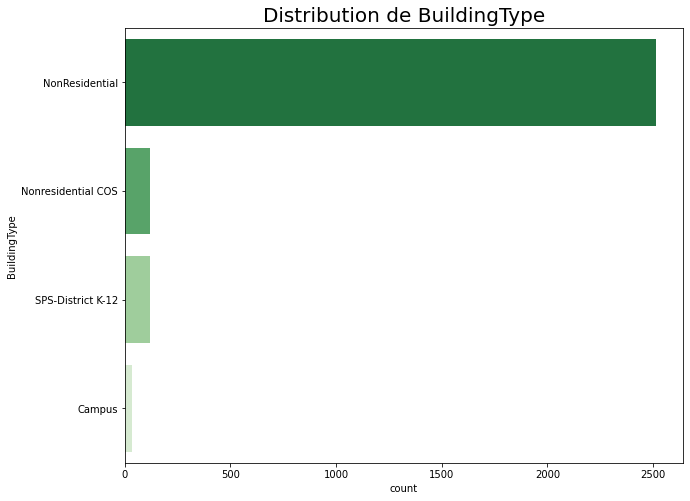

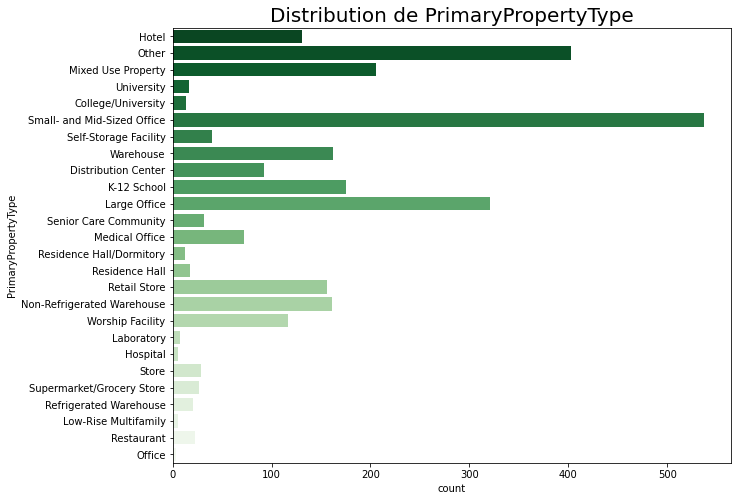

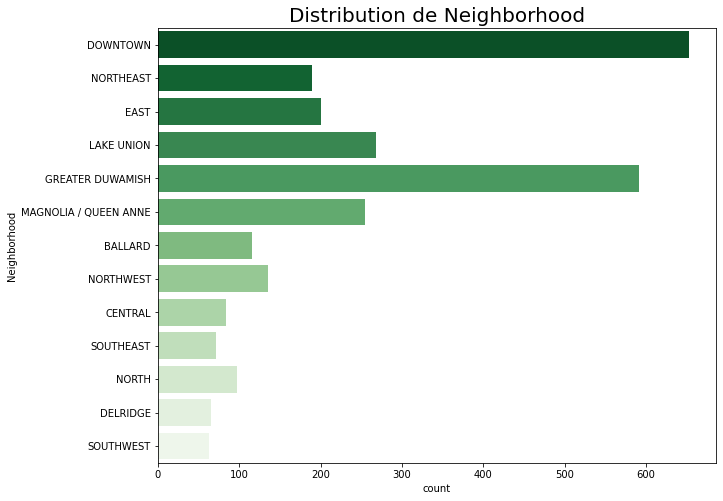

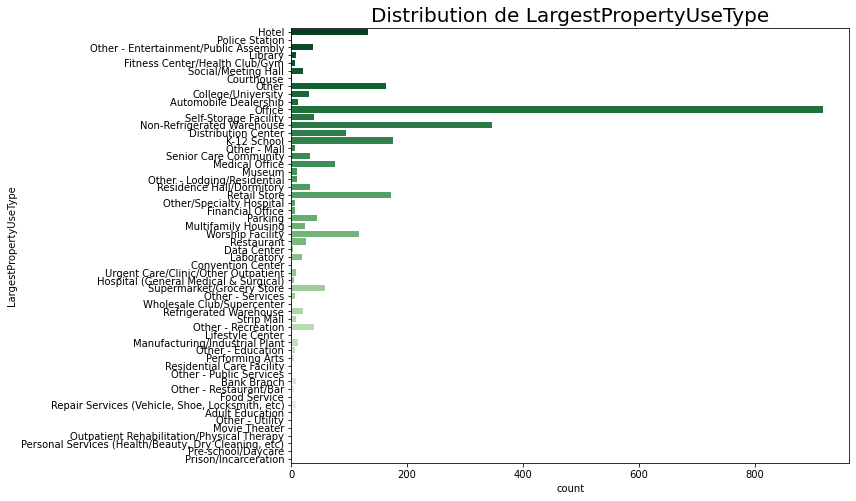

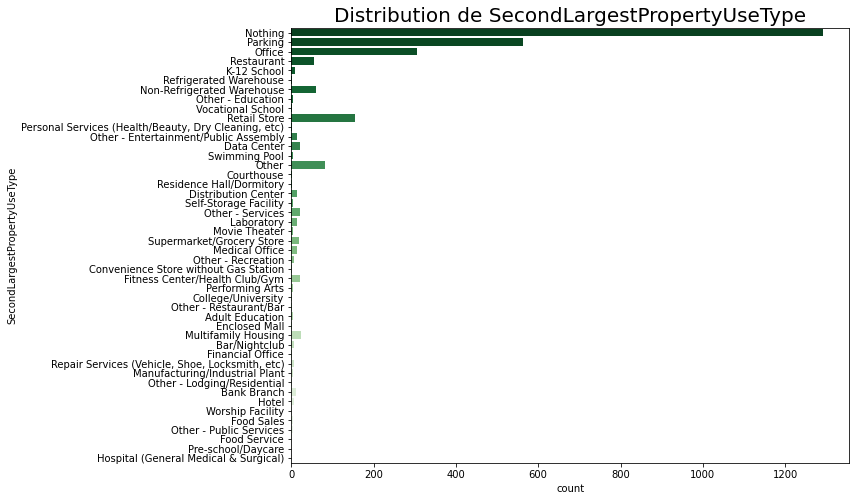

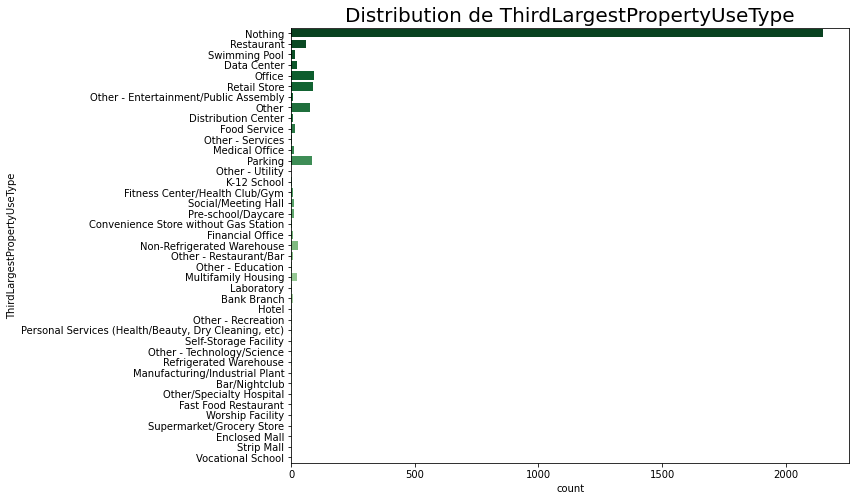

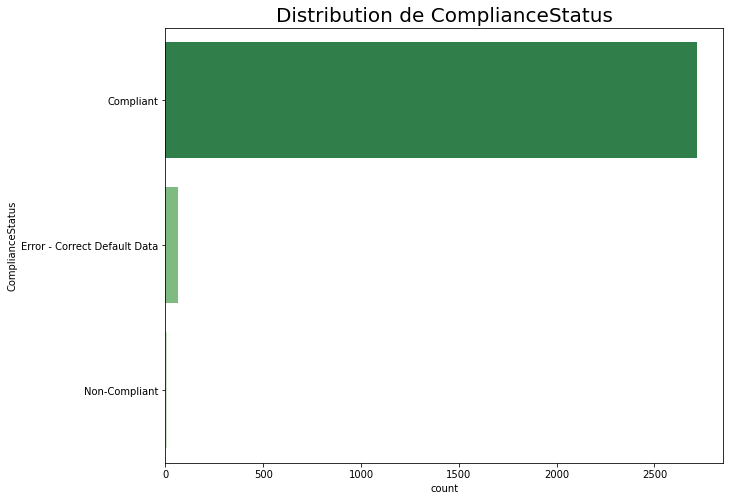

In [ ]:
for col in range(energy_2015_2016[to_categorical].shape[1]):
    plt.figure(figsize=(10,8))
    plot = sns.countplot(y = energy_2015_2016[to_categorical].iloc[:,col], palette = 'Greens_r')
    plt.title(f"Distribution de {energy_2015_2016[to_categorical].iloc[:,col].name}", fontsize = 20)

In [ ]:
fig = px.scatter_mapbox(energy_2015_2016,
                        lat="Latitude",
                        lon="Longitude",
                        color="Neighborhood",
                        mapbox_style = "carto-positron",
                        zoom=9.5,
                        title="<b>Répartion geographique des immeubles par voisinage</b>")
fig.show()

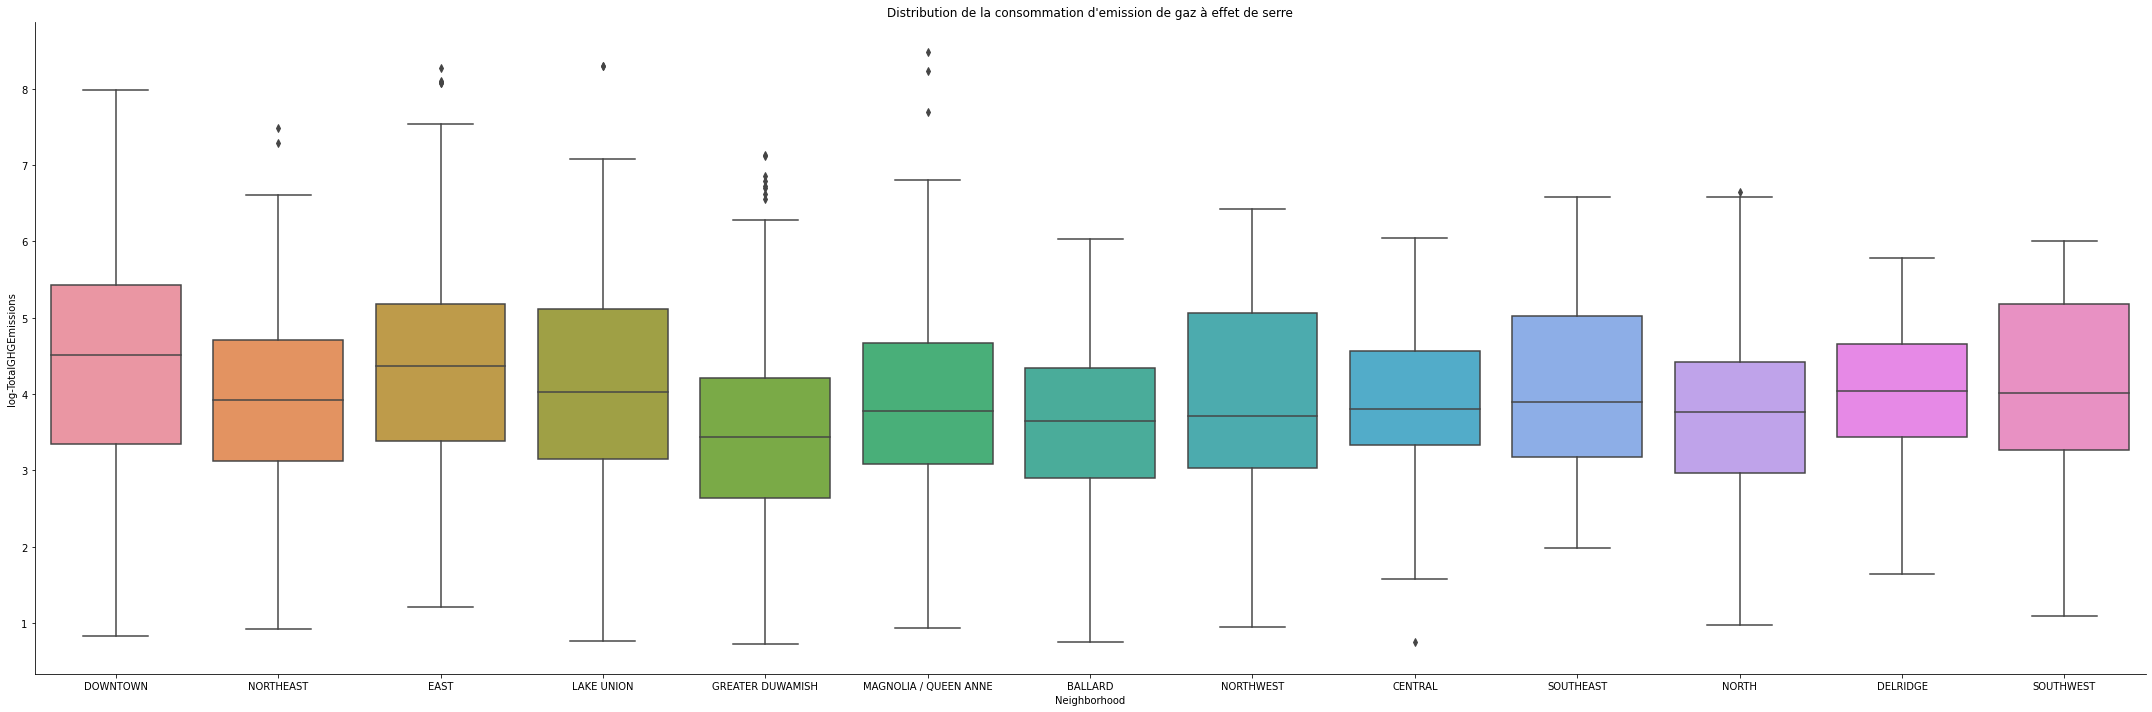

In [ ]:
sns.catplot(x='Neighborhood', y='log-TotalGHGEmissions', data=energy_2015_2016, height=10, aspect=3, kind='box').set(title="Distribution de la consommation d'emission de gaz à effet de serre")
plt.tight_layout()

In [ ]:
import plotly.express as px
fig = px.box(energy_2015_2016, x="Neighborhood", y="log-SiteEnergyUse")
fig.show()

     On peut observer sur le boxplot que le quartier Downtown a la plus haute médianne concernant l'utilisation énergétique. Ce quartier a de fortes probabilités d'avoir des consommations électriques et émissions de gaz à effet de serre plus importantes que les autres quartiers de Seattle.

In [ ]:
fig = px.scatter(
    energy_2015_2016, x='YearBuilt', y='log-SiteEnergyUse', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue',
    title="L'évolution de la consommation énergetique par année"
)
fig.show()

    Plus un bâtiment est récent, plus son utilisation en énergie augmente. 



On supprime les colonnes non pertinentes

In [ ]:
energy_2015_2016.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),...,GHGEmissionsIntensity,ComplianceStatus,Latitude,Longitude,Address,City,State,ZipCode,log-TotalGHGEmissions,log-SiteEnergyUse
0,1,2015,NonResidential,Hotel,DOWNTOWN,1927.0,1.0,12.0,0.0,88434.0,...,2.64,Compliant,47.61219,-122.337997,405 OLIVE WAY,Seattle,WA,98101.0,5.523179,15.758764
0,1,2016,NonResidential,Hotel,DOWNTOWN,1927.0,1.0,12.0,0.0,88434.0,...,2.83,Compliant,47.61220,-122.337990,405 Olive way,Seattle,WA,98101.0,5.525373,15.793246


In [ ]:
list_col = ['OSEBuildingID','ComplianceStatus', 'ZipCode','Address','City','State','Latitude', 'Longitude','DataYear',
            'GHGEmissionsIntensity','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
            'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [ ]:
energy = energy_2015_2016.drop(list_col, axis=1)

In [ ]:
energy.reset_index(drop=True, inplace=True)

In [ ]:
energy.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'log-TotalGHGEmissions', 'log-SiteEnergyUse'],
      dtype='object')

## Encodage binaire des valeurs catégoriques

In [ ]:
to_categorical = energy.select_dtypes(['object','category']).keys()
to_categorical

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood'], dtype='object')

In [ ]:
is_numerical =  energy.select_dtypes(['int','float']).columns
list(is_numerical)

['YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'log-TotalGHGEmissions',
 'log-SiteEnergyUse']

In [ ]:
df = pd.get_dummies(energy, columns=list(to_categorical))

# Modélisation

La modélisation sera réalisée en plusieurs pour comprendre l'importance de l'energy score dans le jeu de données:

- Prédire la consommation énergétique avec le energyscore
- Prédire la consommation énergétique sans le energyscore

- Prédire l'émission de co2 avec le energyscore
- Prédire l'émission de co2 sans le energyscore


In [ ]:
y = df[['log-TotalGHGEmissions','log-SiteEnergyUse']]
X = df.drop(['log-TotalGHGEmissions', 'log-SiteEnergyUse'], axis=1).copy()

In [ ]:
X.columns

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_College/University',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Laboratory',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Non-Refrigerated Warehouse',
       'PrimaryPropertyType_Office', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'Pri

In [ ]:
features = df.drop(['log-TotalGHGEmissions', 'log-SiteEnergyUse'], axis=1).columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)

print('X_train',X_train.shape)
print('X_test:',X_test.shape)
print('y_train',y_train.shape)
print('y_test:',y_test.shape)

X_train (2091, 52)
X_test: (697, 52)
y_train (2091, 2)
y_test: (697, 2)


In [ ]:
#Sans la variable EnergyStarScore
X_train_E = X_train.drop('ENERGYSTARScore', axis=1)
X_test_E = X_test.drop('ENERGYSTARScore', axis=1)

#Variable cible SiteEnergy
y_train_energy = y_train['log-SiteEnergyUse']
y_test_energy = y_test['log-SiteEnergyUse']

#Variable cible TotalGHGEmissions
y_train_emissions = y_train['log-TotalGHGEmissions']
y_test_emissions = y_test['log-TotalGHGEmissions']

## Prédiction SiteEnergyUse(kBtu)

### Comparaison des modèles avec le EnergyStarScore

In [ ]:
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'GradientBoostingRegressor' : GradientBoostingRegressor()
}

#### Avec standardisation

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
results_sc = []
for algo_name, algo in algos.items():
    print('__________________')
    print('Algorithme: ',algo_name)
    print('__________________')
    start = time()
    train_time = time() - start
    model = make_pipeline(algo)
    model.fit(X_train_sc,y_train_energy)
    start = time()
    y_pred_sc = model.predict(X_test_sc)
    predict_time = time()-start
    print("Training time: %0.3fs" % train_time)
    print("Prediction time: %0.3fs" % predict_time)
    print('score d\'entrainement = ',model.score(X_train_sc,y_train_energy))
    print("score de la prédiction: ",  model.score(X_test_sc, y_test_energy))
    mae = mean_absolute_error(y_test_energy,y_pred_sc)
    rmse = np.sqrt(mean_squared_error(y_test_energy,y_pred_sc))
    med_abs_err = median_absolute_error(y_test_energy,y_pred_sc)
    r2 = r2_score(y_test_energy, y_pred_sc)
    print('-------------------')
    results_sc.append([algo_name, model.score(X_test_sc, y_test_energy), mae, rmse, r2, med_abs_err])

__________________
Algorithme:  LinearRegression
__________________
Training time: 0.000s
Prediction time: 0.001s
score d'entrainement =  0.6277728424693766
score de la prédiction:  -4.856848677830316e+23
-------------------
__________________
Algorithme:  Ridge
__________________
Training time: 0.000s
Prediction time: 0.001s
score d'entrainement =  0.6282199273496863
score de la prédiction:  0.6361682953812523
-------------------
__________________
Algorithme:  Lasso
__________________
Training time: 0.000s
Prediction time: 0.000s
score d'entrainement =  0.0
score de la prédiction:  -0.0002347283032422265
-------------------
__________________
Algorithme:  ElasticNet
__________________
Training time: 0.000s
Prediction time: 0.000s
score d'entrainement =  0.15418148151324285
score de la prédiction:  0.16468293772912246
-------------------
__________________
Algorithme:  SVR
__________________
Training time: 0.000s
Prediction time: 0.160s
score d'entrainement =  0.8044244835730772
score

In [ ]:
df_results_sc = pd.DataFrame (results_sc, columns = ['Algo Name','Score de la prédiction','MAE', 'RMSE','R2','median abs err'])
df_results_sc

,Algo Name,Score de la prédiction,MAE,RMSE,R2,median abs err
0,LinearRegression,-4.856849e+23,3.317441e+10,8.758296e+11,-4.856849e+23,0.529907
1,Ridge,6.361683e-01,5.991594e-01,7.580408e-01,6.361683e-01,0.522604
2,Lasso,-2.347283e-04,1.023257e+00,1.256879e+00,-2.347283e-04,0.868439
3,ElasticNet,1.646829e-01,9.473594e-01,1.148598e+00,1.646829e-01,0.837209
4,SVR,7.591664e-01,4.461290e-01,6.167382e-01,7.591664e-01,0.313663
5,RandomForestRegressor,8.918506e-01,2.823556e-01,4.132895e-01,8.918506e-01,0.178590
6,GradientBoostingRegressor,8.480713e-01,3.586941e-01,4.898491e-01,8.480713e-01,0.263306


Le lasso n’est qu’une régression linéaire régularisée, donc pour chaque modèle entraîné, il y a des valeurs pour lesquelles le score sera négatif.

Example : f(x) = w’x + b Où w et x sont des vecteurs et ' est un opérateur de transposition

Quelles que soient les valeurs de w et b, tant que w n’est pas un vecteur zéro - il y a toujours des valeurs de x pour lesquelles f(x)<0.

Et peu importe le jeu d’entraînement utilisé pour calculer w et b ne contienne aucune valeur négative, car le modèle linéaire croisera toujours (peut-être dans certaines très grandes valeurs) la valeur 0.

#### Sans standardisation

In [ ]:
results_SE = []
for algo_name, algo in algos.items():
    print('__________________')
    print('Algorithme: ',algo_name)
    print('__________________')
    start = time()
    train_time = time() - start
    model = make_pipeline(algo)
    model.fit(X_train,y_train_energy)
    start = time()
    y_pred_SE = model.predict(X_test)
    predict_time = time()-start
    print("Training time: %0.3fs" % train_time)
    print("Prediction time: %0.3fs" % predict_time)
    print('score d\'entrainement = ',model.score(X_train,y_train_energy))
    print("score de la prédiction: ",  model.score(X_test, y_test_energy))
    mae = mean_absolute_error(y_test_energy,y_pred_SE)
    rmse = np.sqrt(mean_squared_error(y_test_energy,y_pred_SE))
    med_abs_err = median_absolute_error(y_test_energy,y_pred_SE)
    r2 = r2_score(y_test_energy, y_pred_SE)
    print('-------------------')
    results_SE.append([algo_name, r2, mae, rmse])

__________________
Algorithme:  LinearRegression
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.628779876960061
score de la prédiction:  0.6655391711284446
-------------------
__________________
Algorithme:  Ridge
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.6281259530589158
score de la prédiction:  0.6658717838374812
-------------------
__________________
Algorithme:  Lasso
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.43540353881386207
score de la prédiction:  0.48587934252667464
-------------------
__________________
Algorithme:  ElasticNet
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.4365505962530646
score de la prédiction:  0.4882552420643417
-------------------
__________________
Algorithme:  SVR
__________________
Training time: 0.000s
Prediction time: 0.074s
score d'entrainement =  0.615472792756778


In [ ]:
df_results = pd.DataFrame (results_SE, columns = ['Algo Name','R2', 'MAE', 'RMSE'])

In [ ]:
df_results

,Algo Name,R2,MAE,RMSE
0,LinearRegression,0.665539,0.560179,0.726800
1,Ridge,0.665872,0.560210,0.726439
2,Lasso,0.485879,0.736633,0.901104
3,ElasticNet,0.488255,0.735473,0.899019
4,SVR,0.620537,0.577656,0.774153
5,RandomForestRegressor,0.866244,0.311965,0.459621
6,GradientBoostingRegressor,0.828160,0.379736,0.520959


#### Tuning hyperparameters

Réglage des hyperparamètres pour les modèles ayant les meilleurs score (RandomForestRegressor et GradientBoostingRegressor())

In [ ]:
df_result = df_results[5:]

In [ ]:
df_result["R2_after"] = ""
df_result["RMSE_after"] = ""
df_result["MAE_after"] = ""

In [ ]:
df_result["Target"] = ""
df_result["R2_without_EnergyScore"] = ""
df_result["RMSE_without_EnergyScore"] = ""
df_result["MAE_without_EnergyScore"] = ""

In [ ]:
df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,,,,,,,
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,,,,,,,


#####**GradientBoostingRegressor**

In [ ]:
parameters = { 'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : (0.05,0.25,0.50,1),
              'criterion' : ['friedman_mse', 'mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [ ]:
grid = GridSearchCV(GradientBoostingRegressor(),parameters)

In [ ]:
model = grid.fit(X_train,y_train_energy)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'huber', 'max_features': 'auto'} 

GradientBoostingRegressor(learning_rate=0.5, loss='huber', max_features='auto') 



In [ ]:
y_pred_SE_xg = model.predict(X_test)

In [ ]:
df_result["R2_after"][6] = r2_score(y_test_energy, y_pred_SE_xg)
df_result["RMSE_after"][6] = np.sqrt(mean_squared_error(y_test_energy, y_pred_SE_xg))
df_result["MAE_after"][6] = mean_absolute_error(y_test_energy,y_pred_SE_xg)

df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,,,,,,,
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,0.85152,0.484258,0.348261,,,,


#####**Random Forest Regressor**

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train_energy)

Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 81.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 99.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 116.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 133.9min
[Parallel(n_jobs=-1)]: Done 9097 tasks      |

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400,
                                          1600, 1800, 2000]},
             verbose=2)

In [ ]:
grid_rf = pd.DataFrame(rf_random.cv_results_)

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [ ]:
y_pred_rf_SE = rf_random.predict(X_test)

In [ ]:
df_result["R2_after"][5] = r2_score(y_test_energy, y_pred_rf_SE)
df_result["RMSE_after"][5] = np.sqrt(mean_squared_error(y_test_energy, y_pred_rf_SE))
df_result["MAE_after"][5] = mean_absolute_error(y_test_energy,y_pred_rf_SE)

df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,0.890368,0.416113,0.25808,,,,
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,0.85152,0.484258,0.348261,,,,


In [ ]:
df_result["Target"][5] = "SiteEnergyUse"
df_result["Target"][6] = "SiteEnergyUse"
df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,0.890368,0.416113,0.25808,SiteEnergyUse,,,
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,0.85152,0.484258,0.348261,SiteEnergyUse,,,


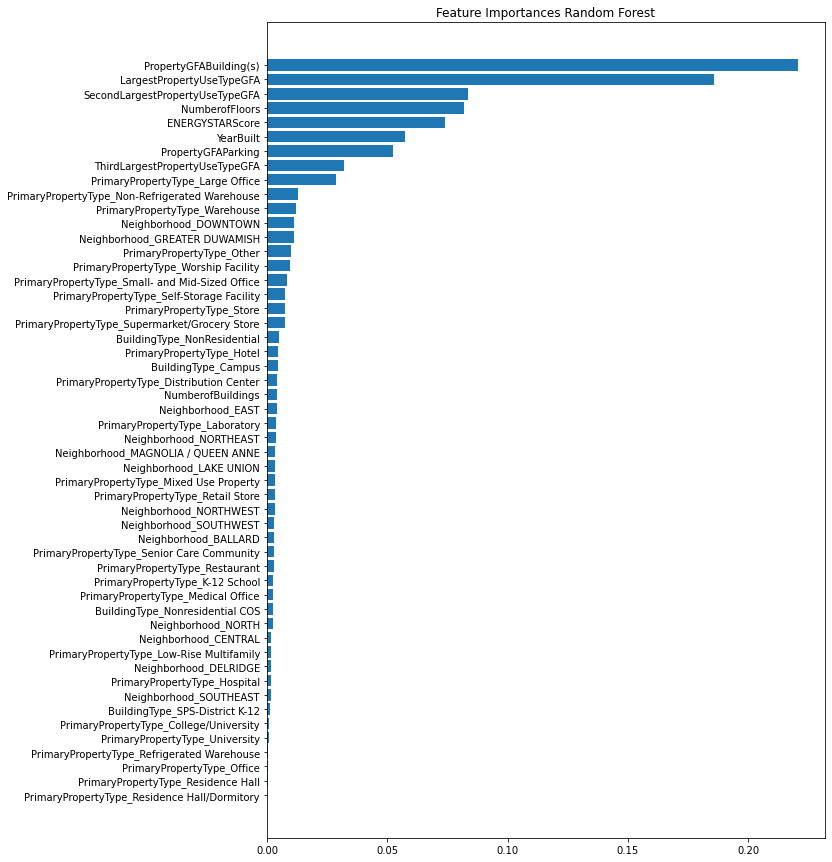

In [ ]:
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 15))
plt.title('Feature Importances Random Forest')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

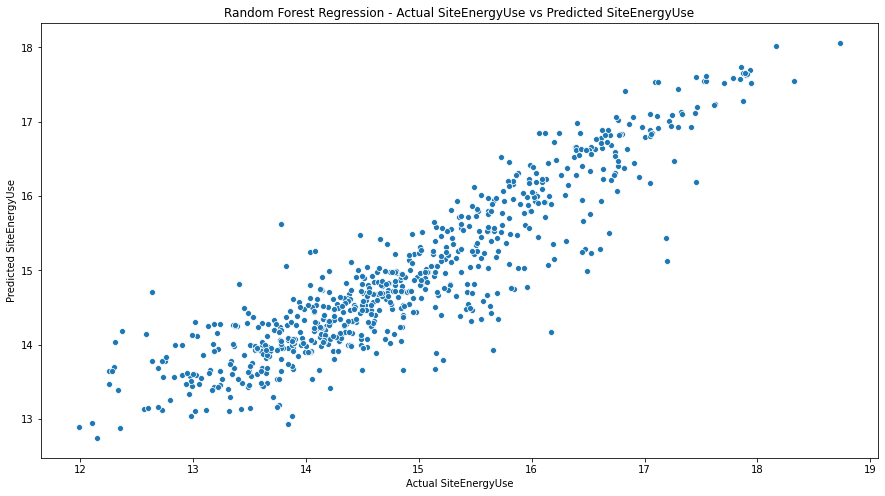

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Random Forest Regression - Actual SiteEnergyUse vs Predicted SiteEnergyUse")

ax = sns.scatterplot(x=y_test_energy, y=y_pred_SE)

ax.set(xlabel="Actual SiteEnergyUse", ylabel="Predicted SiteEnergyUse")
plt.show()

# Comparaison des modèles sans le EnergyStarScore

#####GradientBoostingRegressor

In [ ]:
gb_SE_SansE = GradientBoostingRegressor(criterion = 'friedman_mse', 
                                        learning_rate = 0.5, 
                                        loss = 'huber', 
                                        max_features = 'auto')

In [ ]:
gb_SE_SansE.fit(X_train_E,y_train_energy)

GradientBoostingRegressor(learning_rate=0.5, loss='huber', max_features='auto')

In [ ]:
y_pred_gb_SE_SansE = gb_SE_SansE.predict(X_test_E)

In [ ]:
df_result["R2_without_EnergyScore"][6] = r2_score(y_test_energy, y_pred_gb_SE_SansE)
df_result["RMSE_without_EnergyScore"][6] = np.sqrt(mean_squared_error(y_test_energy, y_pred_gb_SE_SansE))
df_result["MAE_without_EnergyScore"][6] = mean_absolute_error(y_test_energy,y_pred_gb_SE_SansE)

df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,0.890368,0.416113,0.25808,SiteEnergyUse,,,
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,0.85152,0.484258,0.348261,SiteEnergyUse,0.806963,0.552157,0.394347


#####Random Forest Regressor

In [ ]:
rf_SE_SansE = RandomForestRegressor(bootstrap= 'False',
                                    max_depth = 90,
                                    max_features = 'log2',
                                    min_samples_leaf = 1,
                                    min_samples_split = 2,
                                    n_estimators = 600)

In [ ]:
rf_SE_SansE.fit(X_train_E,y_train_energy)

RandomForestRegressor(bootstrap='False', max_depth=90, max_features='log2',
                      n_estimators=600)

In [ ]:
y_pred_SE_SansE = rf_SE_SansE.predict(X_test_E)

In [ ]:
df_result["R2_without_EnergyScore"][5] = r2_score(y_test_energy, y_pred_SE_SansE)
df_result["RMSE_without_EnergyScore"][5] = np.sqrt(mean_squared_error(y_test_energy, y_pred_SE_SansE))
df_result["MAE_without_EnergyScore"][5] = mean_absolute_error(y_test_energy,y_pred_SE_SansE)
df_result

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.866244,0.311965,0.459621,0.890368,0.416113,0.25808,SiteEnergyUse,0.848565,0.489053,0.331932
6,GradientBoostingRegressor,0.828160,0.379736,0.520959,0.85152,0.484258,0.348261,SiteEnergyUse,0.806963,0.552157,0.394347


Le RandomForestRegressor est l'algorithme le plus performant

Text(0.5, 1.0, 'RMSE comparison for SiteEnergyUse')

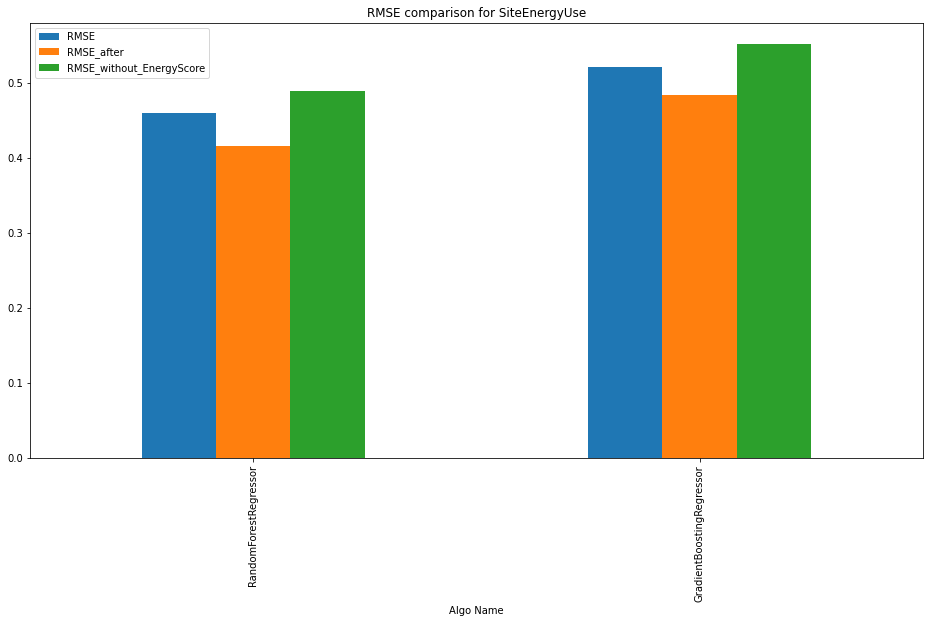

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
df_result.plot(x="Algo Name", y=["RMSE", "RMSE_after","RMSE_without_EnergyScore"], kind="bar")
plt.title("RMSE comparison for SiteEnergyUse")

Text(0.5, 1.0, 'R2 comparison for SiteEnergyUse')

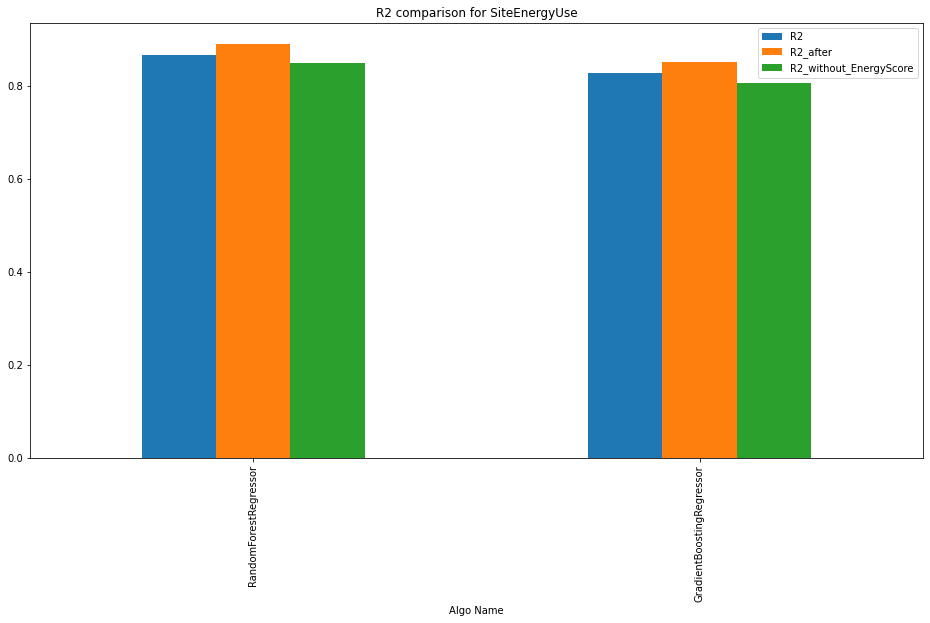

In [ ]:
df_result.plot(x="Algo Name", y=["R2", "R2_after","R2_without_EnergyScore"], kind="bar")
plt.title("R2 comparison for SiteEnergyUse")

## Prédiction GHGEmissions

In [ ]:
results_GH = []
for algo_name, algo in algos.items():
    print('__________________')
    print('Algorithme: ',algo_name)
    print('__________________')
    start = time()
    train_time = time() - start
    model = make_pipeline(algo)
    model.fit(X_train,y_train_emissions)
    start = time()
    y_pred_GH = model.predict(X_test)
    predict_time = time()-start
    print("Training time: %0.3fs" % train_time)
    print("Prediction time: %0.3fs" % predict_time)
    print('score d\'entrainement = ',model.score(X_train,y_train_emissions))
    print("score de la prédiction: ",  model.score(X_test, y_test_emissions))
    mae = mean_absolute_error(y_test_emissions,y_pred_GH)
    rmse = np.sqrt(mean_squared_error(y_test_emissions,y_pred_GH))
    r2 = r2_score(y_test_emissions, y_pred_GH)
    print('-------------------')
    results_GH.append([algo_name, r2, mae, rmse])

__________________
Algorithme:  LinearRegression
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.47960225610306073
score de la prédiction:  0.487708222304137
-------------------
__________________
Algorithme:  Ridge
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.47871693430139317
score de la prédiction:  0.48869180969234594
-------------------
__________________
Algorithme:  Lasso
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.272001227688242
score de la prédiction:  0.3068340689166543
-------------------
__________________
Algorithme:  ElasticNet
__________________
Training time: 0.000s
Prediction time: 0.003s
score d'entrainement =  0.27295213097502335
score de la prédiction:  0.30839163832791006
-------------------
__________________
Algorithme:  SVR
__________________
Training time: 0.000s
Prediction time: 0.075s
score d'entrainement =  0.40139556795105

In [ ]:
df_results_GH = pd.DataFrame (results_GH, columns = ['Algo Name','R2', 'MAE', 'RMSE'])
df_results_GH

,Algo Name,R2,MAE,RMSE
0,LinearRegression,0.487708,0.769355,0.978531
1,Ridge,0.488692,0.768133,0.977591
2,Lasso,0.306834,0.905918,1.138242
3,ElasticNet,0.308392,0.905537,1.136962
4,SVR,0.380937,0.853766,1.075681
5,RandomForestRegressor,0.733123,0.530523,0.706271
6,GradientBoostingRegressor,0.638026,0.650762,0.822536


#### Tuning hyperparameters

Réglage des hyperparamètres pour les modèles ayant les meilleurs score (RandomForestRegressor)

In [ ]:
df_results_GH[5:6]

,Algo Name,R2,MAE,RMSE
5,RandomForestRegressor,0.733123,0.530523,0.706271


In [ ]:
df_results_GH = df_results_GH[5:6]
df_results_GH["R2_after"] = ""
df_results_GH["RMSE_after"] = ""
df_results_GH["MAE_after"] = ""

df_results_GH["Target"] = ""
df_results_GH["R2_without_EnergyScore"] = ""
df_results_GH["RMSE_without_EnergyScore"] = ""
df_results_GH["MAE_without_EnergyScore"] = ""
df_results_GH

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.733123,0.530523,0.706271,,,,,,,


In [ ]:
# Number of trees in random forest
n_estimators = [1, 10, 50, 100, 200, 250, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid_gh = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid_gh)

{'n_estimators': [1, 10, 50, 100, 200, 250, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_gh = GridSearchCV(estimator = rf, param_grid = random_grid_gh, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random_gh.fit(X_train, y_train_emissions)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.2min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [1, 10, 50, 100, 200, 250, 500, 1000]},
             verbose=2)

In [ ]:
rf_random_gh.best_params_

{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [ ]:
y_pred_rf_GH = rf_random_gh.predict(X_test)

In [ ]:
df_results_GH["R2_after"][5] = r2_score(y_test_emissions, y_pred_rf_GH)
df_results_GH["RMSE_after"][5] = np.sqrt(mean_squared_error(y_test_emissions, y_pred_rf_GH))
df_results_GH["MAE_after"][5] = mean_absolute_error(y_test_emissions,y_pred_rf_GH)

df_results_GH

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.733123,0.530523,0.706271,0.790287,0.626079,0.419253,,,,


In [ ]:
df_results_GH["Target"][5] = "GHGEmissions"
df_results_GH

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.733123,0.530523,0.706271,0.790287,0.626079,0.419253,GHGEmissions,,,


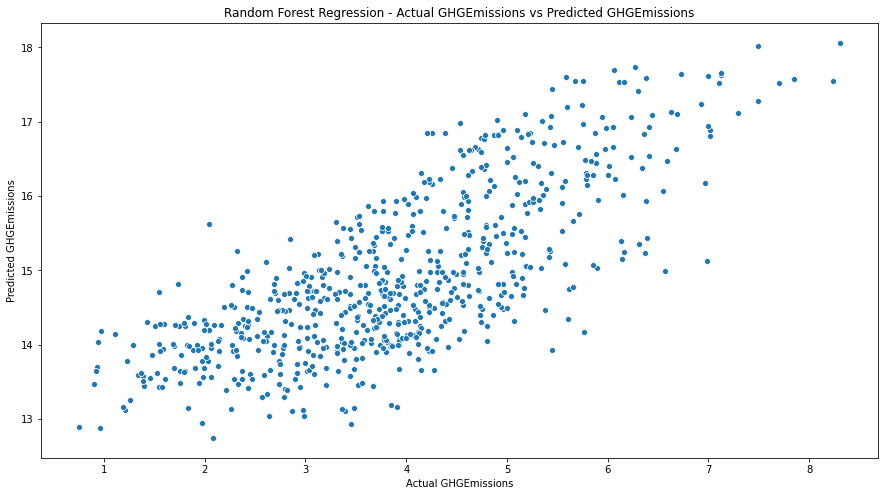

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Random Forest Regression - Actual GHGEmissions vs Predicted GHGEmissions")

ax = sns.scatterplot(x=y_test_emissions, y=y_pred_SE)

ax.set(xlabel="Actual GHGEmissions", ylabel="Predicted GHGEmissions")
plt.show()

# Comparaison du modèle sans le EnergyStarScore

In [ ]:
rf_GH_SansE = RandomForestRegressor(bootstrap= 'False',
                                    max_features = 'sqrt',
                                    min_samples_leaf = 1,
                                    n_estimators = 200)

In [ ]:
rf_GH_SansE.fit(X_train_E,y_train_emissions)

RandomForestRegressor(bootstrap='False', max_features='sqrt', n_estimators=200)

In [ ]:
y_pred_GH_SansE = rf_GH_SansE.predict(X_test_E)

In [ ]:
df_results_GH["R2_without_EnergyScore"][5] = r2_score(y_test_emissions, y_pred_GH_SansE)
df_results_GH["RMSE_without_EnergyScore"][5] = np.sqrt(mean_squared_error(y_test_emissions, y_pred_GH_SansE))
df_results_GH["MAE_without_EnergyScore"][5] = mean_absolute_error(y_test_emissions,y_pred_GH_SansE)

df_results_GH

,Algo Name,R2,MAE,RMSE,R2_after,RMSE_after,MAE_after,Target,R2_without_EnergyScore,RMSE_without_EnergyScore,MAE_without_EnergyScore
5,RandomForestRegressor,0.733123,0.530523,0.706271,0.790287,0.626079,0.419253,GHGEmissions,0.741758,0.694752,0.503943


(array([0]), [Text(0, 0, 'RandomForestRegressor')])

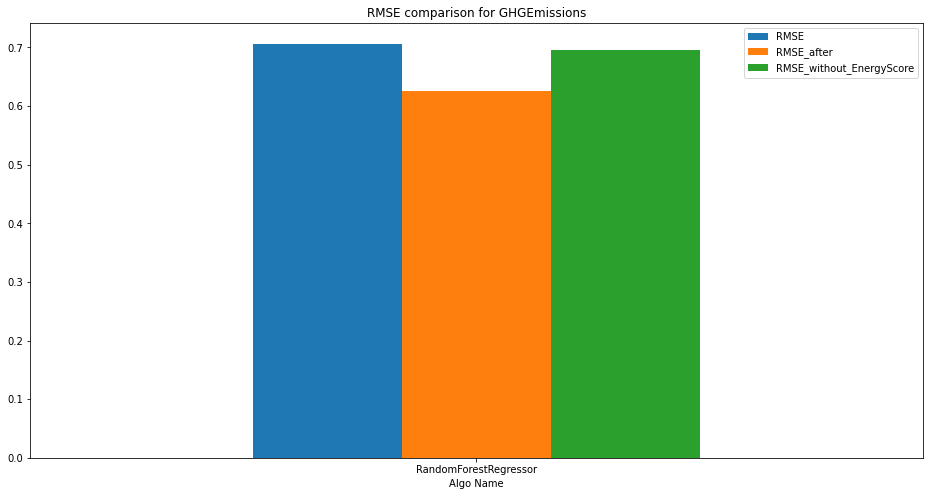

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)
df_results_GH.plot(x="Algo Name", y=["RMSE", "RMSE_after","RMSE_without_EnergyScore"], kind="bar")
plt.title("RMSE comparison for GHGEmissions")
plt.xticks(rotation=0)

Text(0.5, 1.0, 'R2 comparison for SiteEnergyUse')

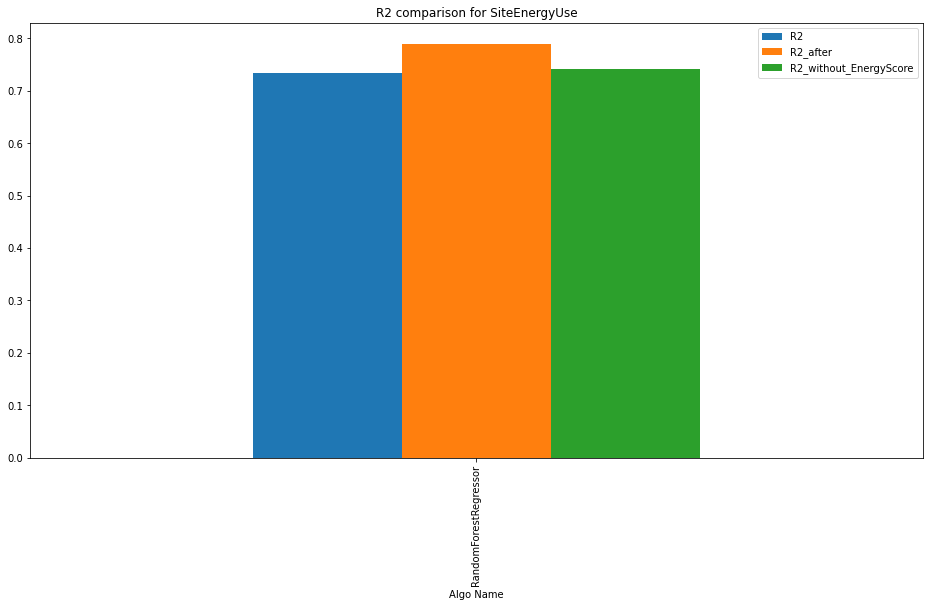

In [ ]:
df_results_GH.plot(x="Algo Name", y=["R2", "R2_after","R2_without_EnergyScore"], kind="bar")
plt.title("R2 comparison for SiteEnergyUse")

# L'importance de l'energy score

La variable EnergyScore apporte de l’amélioration au modèle mais y a peut d’intéret de l’utiliser car on peut arriver au même résultats en optimisant les hyperparamètres du modèle.